In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

Reaction  Days Subject
1   249.5600     0     308
2   258.7047     1     308
3   250.8006     2     308
4   321.4398     3     308
5   356.8519     4     308
6   414.6901     5     308
7   382.2038     6     308
8   290.1486     7     308
9   430.5853     8     308
10  466.3535     9     308
11  222.7339     0     309
12  205.2658     1     309
13  202.9778     2     309
14  204.7070     3     309
15  207.7161     4     309

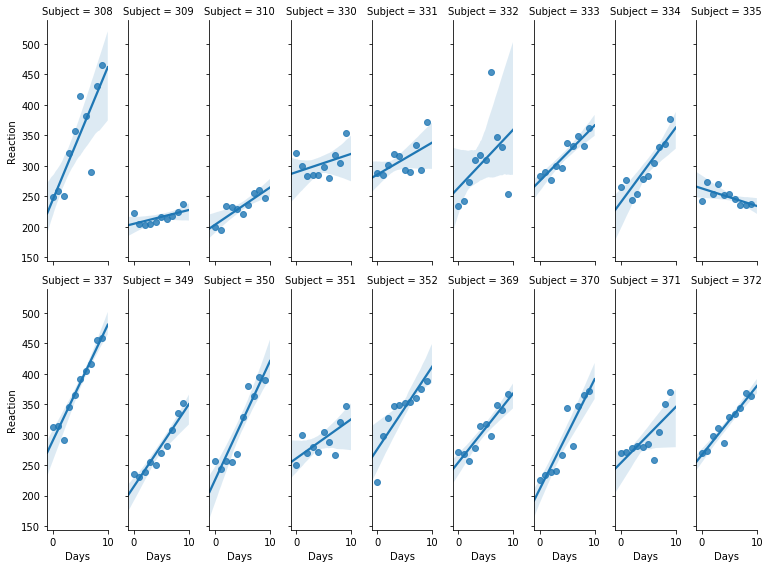

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Model 1: Random effect on only the intercepts

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercecpt by some amount, but the slope will be the same across participants

In [5]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [7]:
with pm.Model() as model:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, gamma_Z_raw, scaler_Z_log__, beta_X_slope, beta_X_intercept_log__]
The number of effective samples is smaller than 25% for some parameters.


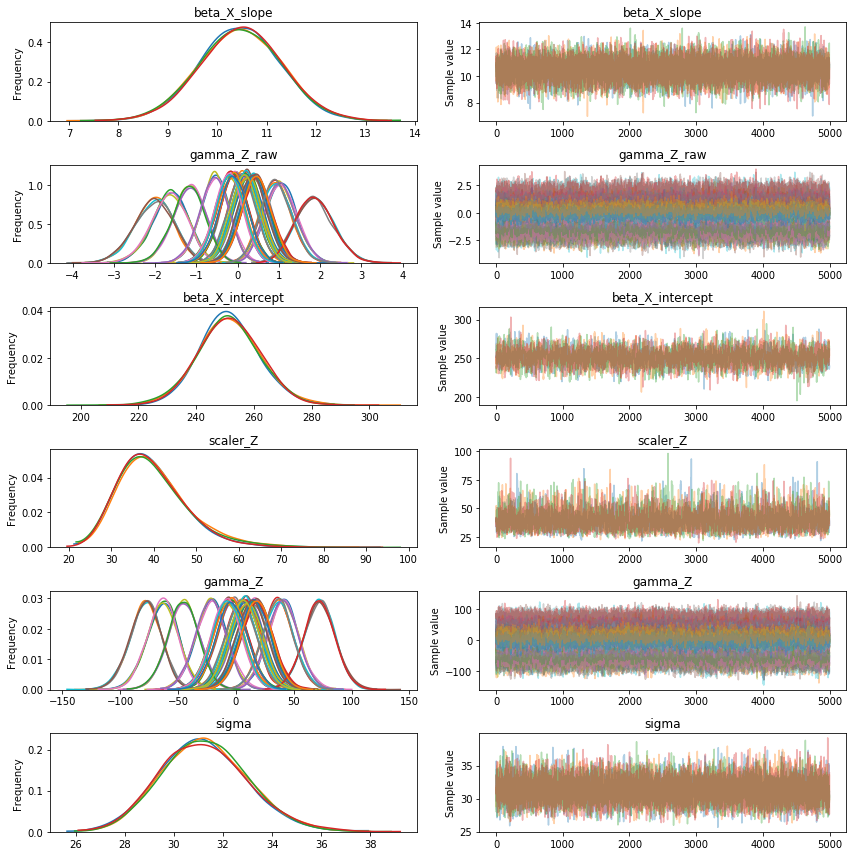

In [8]:
_ = pm.traceplot(trace)

In [9]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope       10.469492   0.815929  0.005161    8.839172   12.031284   
gamma_Z_raw__0      1.054315   0.380373  0.006393    0.315490    1.800344   
gamma_Z_raw__1     -2.026309   0.475562  0.006905   -2.983420   -1.115639   
gamma_Z_raw__2     -1.643727   0.431851  0.006044   -2.525806   -0.825130   
gamma_Z_raw__3      0.113409   0.340193  0.005447   -0.567469    0.768975   
gamma_Z_raw__4      0.262841   0.346661  0.005457   -0.412173    0.943548   
gamma_Z_raw__5      0.212291   0.339843  0.005429   -0.451784    0.881903   
gamma_Z_raw__6      0.423302   0.345342  0.005328   -0.259544    1.102269   
gamma_Z_raw__7     -0.082505   0.337870  0.005271   -0.732411    0.596764   
gamma_Z_raw__8     -1.179640   0.390615  0.005531   -1.946896   -0.431278   
gamma_Z_raw__9      1.873743   0.463135  0.007877    0.982205    2.783785   
gamma_Z_raw__10    -0.555408   0.350744  0.005165   -1.258173    0.124371   
gamma_Z_raw__11     0.363644   0.345319  0.005636   -0.323541    1.029426   
gamma_Z_raw__12    -0.206252   0.342643  0.005336   -0.880673    0.459875   
gamma_Z_raw__13     0.942545   0.372780  0.006185    0.224909    1.680971   
gamma_Z_raw__14     0.181973   0.342339  0.005391   -0.491088    0.851481   
gamma_Z_raw__15    -0.166651   0.340557  0.005017   -0.844843    0.490871   
gamma_Z_raw__16    -0.088668   0.341671  0.005351   -0.764629    0.585136   
gamma_Z_raw__17     0.470878   0.348919  0.005466   -0.205439    1.164658   
beta_X_intercept  251.517338  10.510953  0.214446  232.105935  273.547600   
scaler_Z           39.863775   8.072136  0.127247   25.795474   55.759606   
gamma_Z__0         40.646643  13.317119  0.217475   14.214284   66.857392   
gamma_Z__1        -78.172498  13.542696  0.216835 -105.750784  -52.700733   
gamma_Z__2        -63.421227  13.419440  0.216081  -90.899960  -38.291365   
gamma_Z__3          4.350307  13.345342  0.221633  -21.742710   30.703232   
gamma_Z__4         10.093938  13.413088  0.216227  -17.082586   35.256257   
gamma_Z__5          8.150614  13.299039  0.217892  -18.015046   34.059490   
gamma_Z__6         16.300341  13.214071  0.208378   -9.011830   42.978121   
gamma_Z__7         -3.220169  13.241790  0.217401  -28.696527   23.332302   
gamma_Z__8        -45.518188  13.459139  0.214792  -71.792736  -19.223221   
gamma_Z__9         72.223703  13.424111  0.205833   45.253465   98.564574   
gamma_Z__10       -21.441844  13.322353  0.217823  -47.964909    4.667655   
gamma_Z__11        14.006505  13.351179  0.220194  -12.489040   39.955412   
gamma_Z__12        -7.974765  13.394617  0.225333  -34.047441   18.546015   
gamma_Z__13        36.330957  13.310620  0.211894   10.547743   63.000925   
gamma_Z__14         6.965286  13.393649  0.220960  -20.581175   31.987049   
gamma_Z__15        -6.450761  13.331642  0.209390  -32.737599   19.606517   
gamma_Z__16        -3.442416  13.425427  0.221347  -29.847241   22.926031   
gamma_Z__17        18.123318  13.322104  0.211100   -8.371554   44.096117   
sigma              31.252342   1.753474  0.017461   27.864772   34.674409   

                         n_eff      Rhat  
beta_X_slope      14520.587960  1.000237  
gamma_Z_raw__0     3879.167549  1.000461  
gamma_Z_raw__1     4079.823398  1.000541  
gamma_Z_raw__2     4383.342595  1.000486  
gamma_Z_raw__3     4198.877674  1.000179  
gamma_Z_raw__4     4188.048244  1.000199  
gamma_Z_raw__5     4383.387231  1.000190  
gamma_Z_raw__6     4382.825689  1.000355  
gamma_Z_raw__7     4472.295042  1.000115  
gamma_Z_raw__8     4470.442971  1.000416  
gamma_Z_raw__9     3678.607085  1.000481  
gamma_Z_raw__10    4669.341426  1.000532  
gamma_Z_raw__11    4236.013292  1.000084  
gamma_Z_raw__12    4560.309488  1.000292  
gamma_Z_raw__13    3898.040212  1.000335  
gamma_Z_raw__14    4493.973936  1.000287  
gamma_Z_raw__15    4543.863507  1.000156  
gamma_Z_raw__16    4646.319642  1.000261  
gamma_Z_raw__17    4279.546518  1.000133  
beta_X

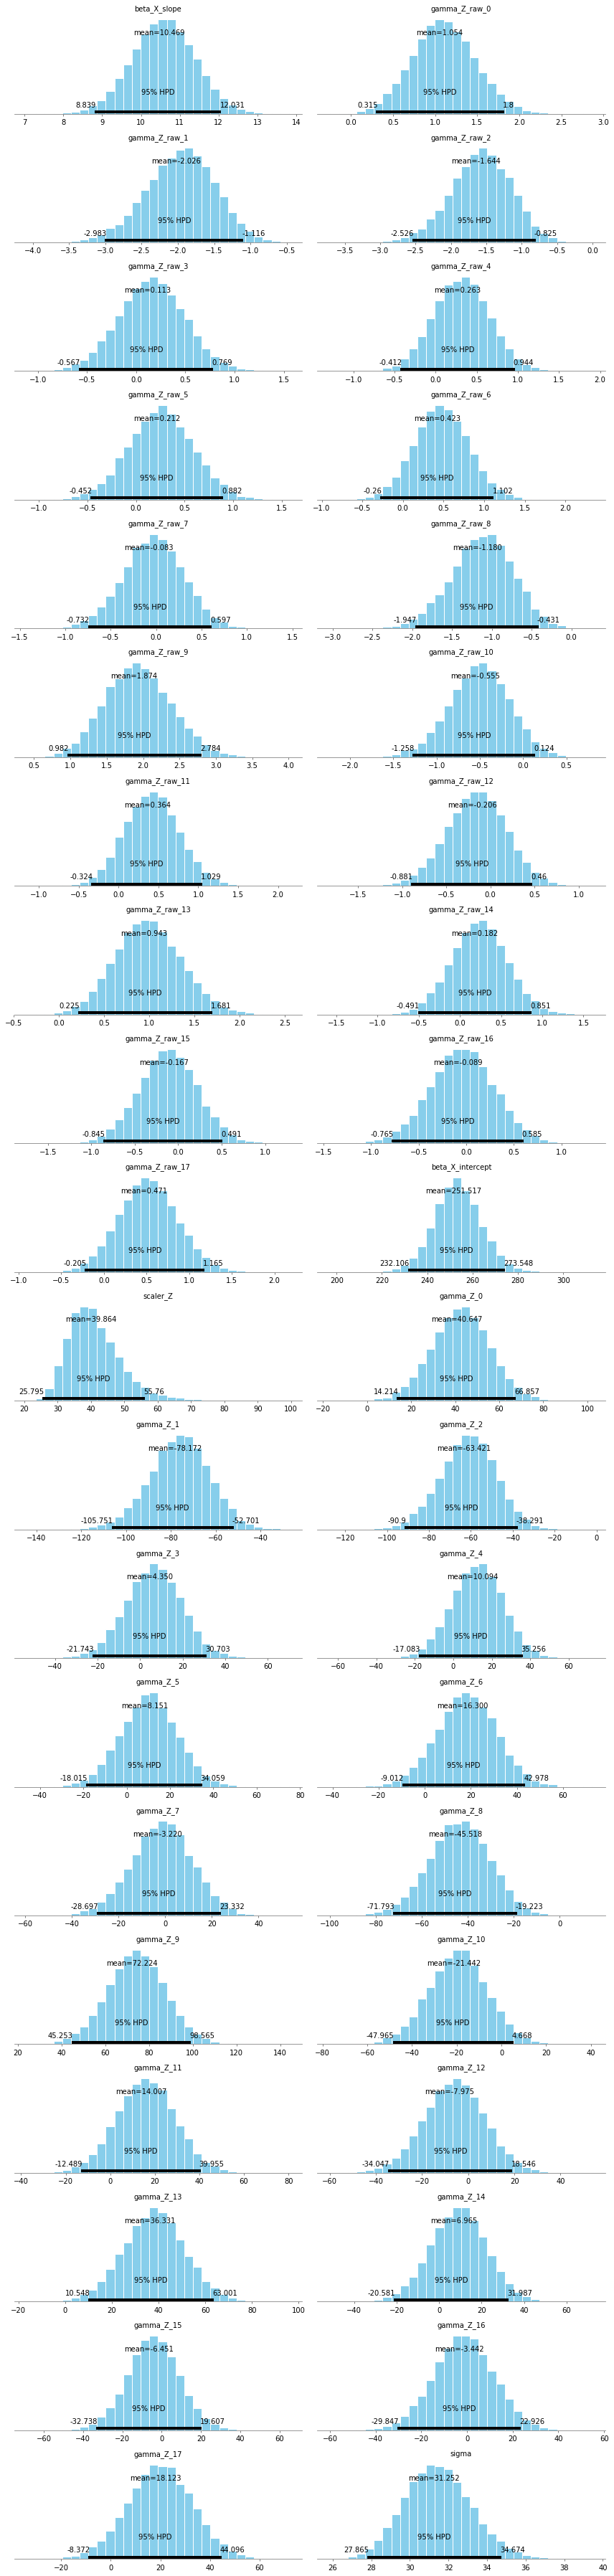

In [10]:
pm.plot_posterior(trace);

## Posterior predictive check

In [11]:
trace_df = pm.trace_to_dataframe(trace)

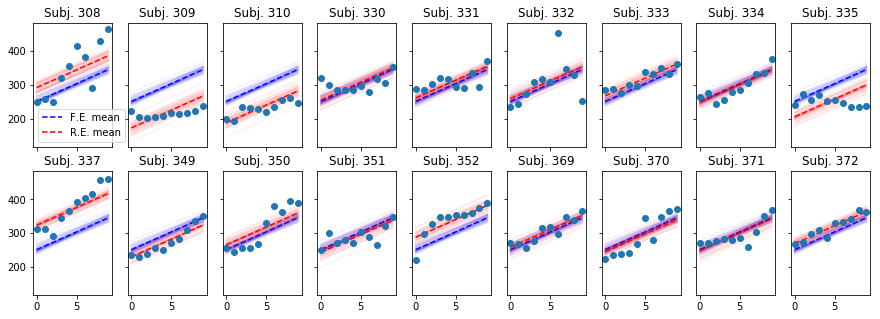

In [12]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0 in trace_df['gamma_Z__{}'.format(i)][::500]:
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * trace_df['beta_X_slope'].mean(), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [13]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:15, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [14]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [15]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [17]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [18]:
Y = np.asarray(sleep['Reaction'])

In [19]:
with pm.Model() as model:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_slope_raw, scaler_slope_log__, gamma_Z_intercept_raw, scaler_intercept_log__, beta_X_slope, beta_X_intercept_log__]


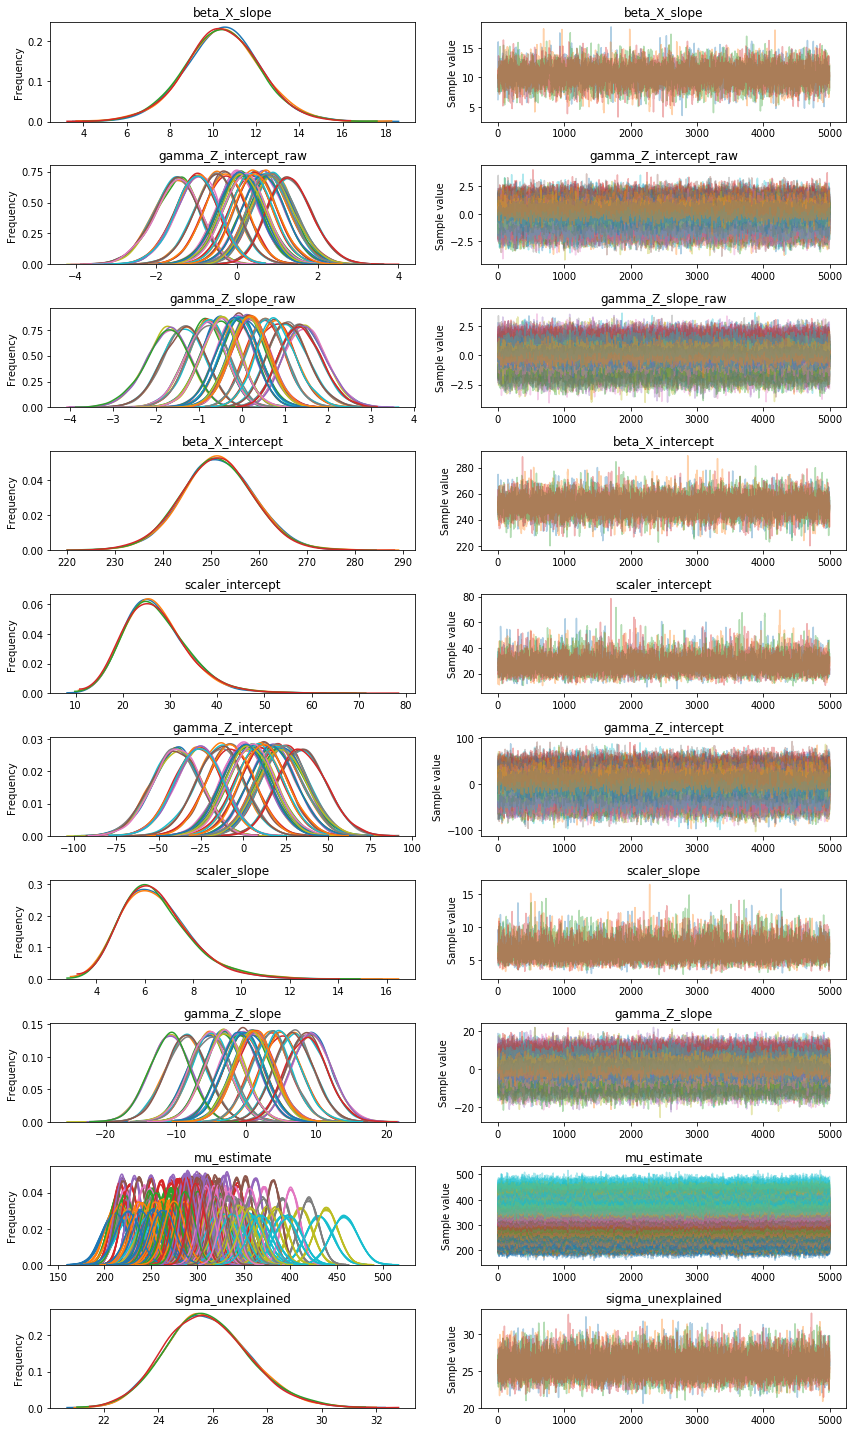

In [20]:
_ = pm.traceplot(trace)

In [21]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5  \
beta_X_slope                10.445379   1.713155  0.019615    6.963216   
gamma_Z_intercept_raw__0     0.046352   0.532885  0.004444   -0.960829   
gamma_Z_intercept_raw__1    -1.535492   0.561348  0.004298   -2.635770   
gamma_Z_intercept_raw__2    -1.490360   0.566945  0.004670   -2.633712   
gamma_Z_intercept_raw__3     0.940355   0.537868  0.004005   -0.066028   
gamma_Z_intercept_raw__4     0.879856   0.542956  0.004073   -0.161403   
gamma_Z_intercept_raw__5     0.356585   0.532933  0.003972   -0.704800   
gamma_Z_intercept_raw__6     0.659875   0.536536  0.003862   -0.380421   
gamma_Z_intercept_raw__7    -0.292395   0.528102  0.003877   -1.327366   
gamma_Z_intercept_raw__8     0.028921   0.538820  0.003769   -0.997746   
gamma_Z_intercept_raw__9     1.322590   0.555503  0.004713    0.288524   
gamma_Z_intercept_raw__10   -0.983795   0.545622  0.003987   -2.057438   
gamma_Z_intercept_raw__11   -0.531649   0.537130  0.003855   -1.656540   
gamma_Z_intercept_raw__12    0.194973   0.535705  0.003989   -0.840203   
gamma_Z_intercept_raw__13    0.797456   0.538046  0.004232   -0.228280   
gamma_Z_intercept_raw__14    0.124933   0.530613  0.003754   -0.890963   
gamma_Z_intercept_raw__15   -1.015960   0.542873  0.004306   -2.127202   
gamma_Z_intercept_raw__16    0.035580   0.530780  0.003321   -1.005613   
gamma_Z_intercept_raw__17    0.473942   0.527586  0.004074   -0.516308   
gamma_Z_slope_raw__0         1.490287   0.490005  0.004573    0.566960   
gamma_Z_slope_raw__1        -1.361949   0.493526  0.004556   -2.310258   
gamma_Z_slope_raw__2        -0.859355   0.466461  0.003921   -1.754053   
gamma_Z_slope_raw__3        -0.793858   0.463291  0.004155   -1.703115   
gamma_Z_slope_raw__4        -0.510889   0.455756  0.004100   -1.425030   
gamma_Z_slope_raw__5        -0.051641   0.444640  0.003441   -0.903858   
gamma_Z_slope_raw__6        -0.045987   0.450390  0.003404   -0.919287   
gamma_Z_slope_raw__7         0.181931   0.441903  0.003909   -0.696251   
gamma_Z_slope_raw__8        -1.736783   0.515955  0.004720   -2.792316   
gamma_Z_slope_raw__9         1.374722   0.488065  0.004565    0.444886   
gamma_Z_slope_raw__10        0.208937   0.448335  0.003912   -0.639858   
gamma_Z_slope_raw__11        1.083676   0.476158  0.004346    0.161511   
gamma_Z_slope_raw__12       -0.490806   0.449674  0.004177   -1.430305   
gamma_Z_slope_raw__13        0.557994   0.451236  0.003793   -0.317083   
gamma_Z_slope_raw__14        0.138384   0.445583  0.003601   -0.730563   
gamma_Z_slope_raw__15        0.803860   0.465227  0.004149   -0.079385   
gamma_Z_slope_raw__16       -0.158323   0.447015  0.003424   -1.020548   
gamma_Z_slope_raw__17        0.202678   0.442101  0.003353   -0.659124   
beta_X_intercept           251.407131   7.473937  0.077309  236.686675   
scaler_intercept            27.102499   6.670172  0.084044   15.386271   
gamma_Z_intercept__0         1.242386  13.896984  0.114999  -25.486032   
gamma_Z_intercept__1       -40.382654  14.448267  0.116520  -67.853247   
gamma_Z_intercept__2       -39.148154  14.483358  0.115359  -68.509831   
gamma_Z_intercept__3        24.690552  13.890276  0.105459   -2.695197   
gamma_Z_intercept__4        23.126798  14.080336  0.115654   -3.529391   
gamma_Z_intercept__5         9.401784  13.889678  0.102808  -17.906400   
gamma_Z_intercept__6        17.322075  13.922175  0.097467  -10.150067   
gamma_Z_intercept__7        -7.678862  13.770490  0.103896  -34.731682   
gamma_Z_intercept__8         0.772065  13.991991  0.102787  -27.872932   
gamma_Z_intercept__9        34.804481  14.383214  0.108141    7.291534   
gamma_Z_intercept__10      -25.878107  14.128318  0.115142  -54.004766   
gamma_Z_intercept__11      -13.988144  13.955835  0.108297  -41.841009   
gamma_Z_intercept__12        5.105814  13.929362  0.104998  -21.885177   
gamma_Z_intercept__13       20.989977  13.941774  0.101821   -5.621069   
gamma_Z_intercept__14        3.263035

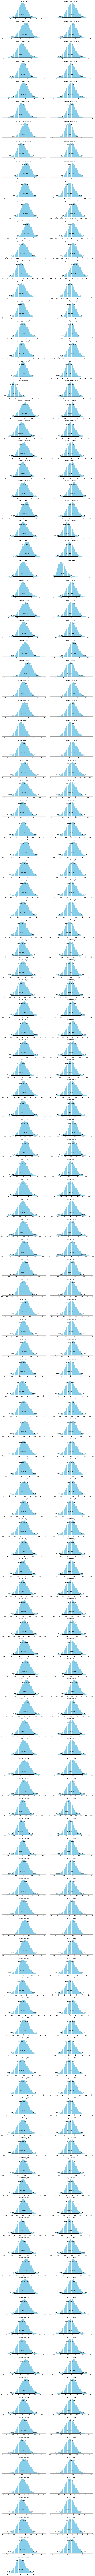

In [22]:
pm.plot_posterior(trace);

In [23]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

0           1           2           3  \
beta_X_slope                 6.217858    6.555119   14.528692   16.041782   
gamma_Z_intercept_raw__0    -0.289602    0.308226   -0.508281   -0.268498   
gamma_Z_intercept_raw__1    -0.996439   -0.695737   -2.278784   -1.986055   
gamma_Z_intercept_raw__2    -1.469343   -1.353824   -1.458141   -1.397757   
gamma_Z_intercept_raw__3     1.280702    0.369940    0.957944    1.079617   
gamma_Z_intercept_raw__4     1.186405    0.540376    0.868964    0.867230   
gamma_Z_intercept_raw__5     0.380514    0.506548   -0.477440   -0.424863   
gamma_Z_intercept_raw__6     0.083143    1.488224   -0.149660   -0.167083   
gamma_Z_intercept_raw__7     0.229008   -0.324950   -1.411607   -1.650779   
gamma_Z_intercept_raw__8     1.075279    0.263406   -0.977120   -0.880784   
gamma_Z_intercept_raw__9     1.837020    1.831809    0.260638    0.280113   
gamma_Z_intercept_raw__10   -0.374911   -0.914531   -1.535591   -1.542813   
gamma_Z_intercept_raw__11    0.057744    0.048351   -1.380920   -1.833946   
gamma_Z_intercept_raw__12    0.766908    0.240421   -0.151840    0.117651   
gamma_Z_intercept_raw__13    0.874388    1.416729   -0.181757   -0.267319   
gamma_Z_intercept_raw__14    0.442148   -0.411356   -0.666369   -0.381660   
gamma_Z_intercept_raw__15   -0.539560   -1.327290   -0.811562   -1.047683   
gamma_Z_intercept_raw__16    0.398049    0.468882   -0.618998   -0.920796   
gamma_Z_intercept_raw__17    0.285802    0.383048    0.403747    0.068862   
gamma_Z_slope_raw__0         2.781364    2.014988    0.320466    0.594205   
gamma_Z_slope_raw__1        -1.080257   -1.136738   -1.372086   -1.243930   
gamma_Z_slope_raw__2        -0.272316   -0.080683   -1.308556   -1.455423   
gamma_Z_slope_raw__3        -0.324148    0.427352   -1.371392   -1.411714   
gamma_Z_slope_raw__4        -0.071350    0.516120   -1.229537   -1.328645   
gamma_Z_slope_raw__5         0.867697    0.619423   -0.532242   -0.519860   
gamma_Z_slope_raw__6         1.244687    0.114889   -0.456358   -0.653019   
gamma_Z_slope_raw__7         0.520353    0.747322   -0.217428   -0.242280   
gamma_Z_slope_raw__8        -1.783872   -1.017446   -1.805018   -1.602457   
gamma_Z_slope_raw__9         1.868644    1.294977    0.542444    0.640918   
gamma_Z_slope_raw__10        0.447114    0.934797   -0.315615   -0.262800   
gamma_Z_slope_raw__11        1.546457    1.290675    0.372305    0.511748   
gamma_Z_slope_raw__12        0.034054    0.242527   -1.025138   -1.192189   
gamma_Z_slope_raw__13        1.435398    0.890697    0.215746    0.108581   
gamma_Z_slope_raw__14        0.715037    0.898528   -0.573289   -0.484429   
gamma_Z_slope_raw__15        1.079095    1.815560   -0.262389   -0.302134   
gamma_Z_slope_raw__16        0.583360    0.122704   -0.627478   -0.525655   
gamma_Z_slope_raw__17        1.020375    1.122436   -0.581689   -0.632186   
beta_X_intercept           246.434689  243.802467  274.721787  269.401117   
scaler_intercept            27.603778   33.015909   29.796097   31.029738   
gamma_Z_intercept__0        -7.994098   10.176372  -15.144776   -8.331433   
gamma_Z_intercept__1       -27.505485  -22.970389  -67.898877  -61.626764   
gamma_Z_intercept__2       -40.559412  -44.697744  -43.446898  -43.372037   
gamma_Z_intercept__3        35.352205   12.213913   28.542993   33.500228   
gamma_Z_intercept__4        32.749260   17.840994   25.891749   26.909931   
gamma_Z_intercept__5        10.503611   16.724144  -14.225851  -13.183380   
gamma_Z_intercept__6         2.295072   49.135061   -4.459272   -5.184539   
gamma_Z_intercept__7         6.321495  -10.728508  -42.060381  -51.223236   
gamma_Z_intercept__8        29.681764    8.696590  -29.114374  -27.330503   
gamma_Z_intercept__9        50.708680   60.478856    7.766000    8.691844   
gamma_Z_intercept__10      -10.348967  -30.194086  -45.754616  -47.873087   
gamma_Z_intercept__11        1.593948    1.596336  -41.146028  -56.906867   
gamma_Z_intercept__12       21.1

In [24]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

xvars

['gamma_Z_intercept__0',
 'gamma_Z_intercept__1',
 'gamma_Z_intercept__2',
 'gamma_Z_intercept__3',
 'gamma_Z_intercept__4',
 'gamma_Z_intercept__5',
 'gamma_Z_intercept__6',
 'gamma_Z_intercept__7',
 'gamma_Z_intercept__8',
 'gamma_Z_intercept__9',
 'gamma_Z_intercept__10',
 'gamma_Z_intercept__11',
 'gamma_Z_intercept__12',
 'gamma_Z_intercept__13',
 'gamma_Z_intercept__14',
 'gamma_Z_intercept__15',
 'gamma_Z_intercept__16',
 'gamma_Z_intercept__17']

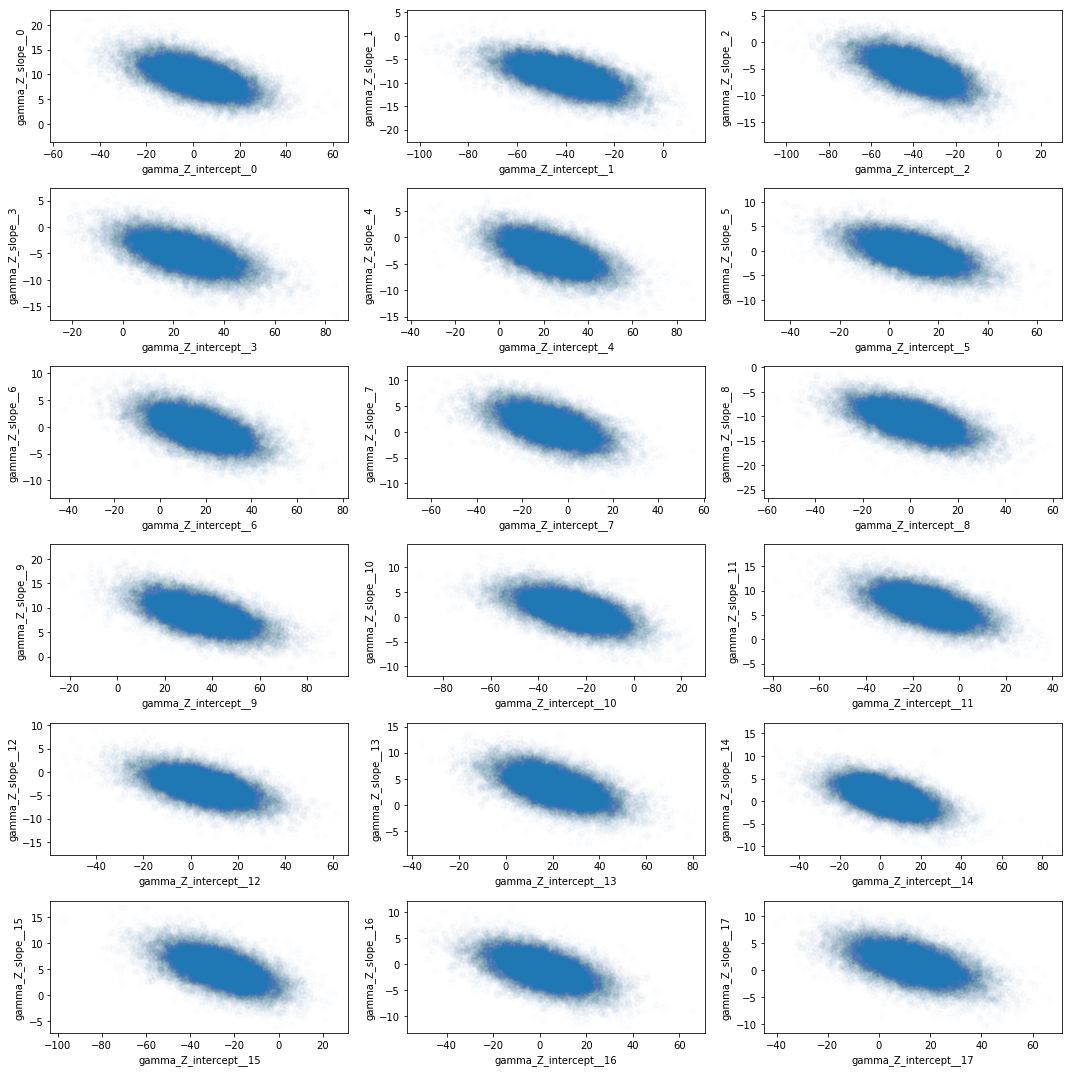

In [25]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    
plt.tight_layout()

## Posterior predictive check

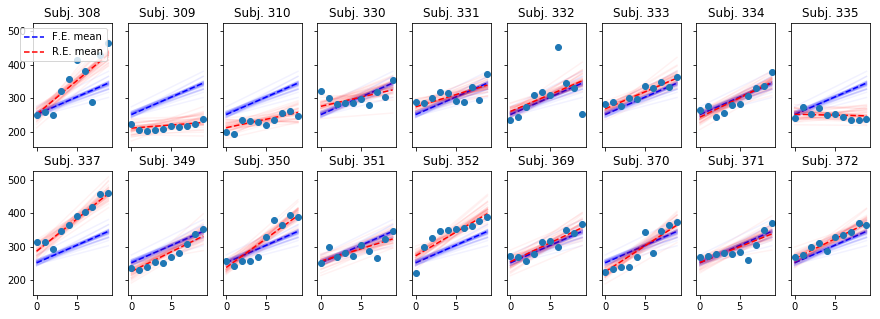

In [26]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

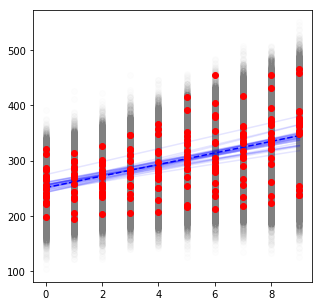

In [27]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [103]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1357.73it/s]


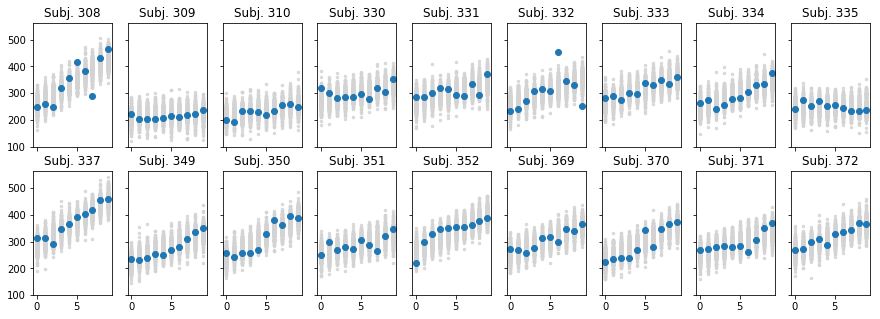

In [104]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


## Model 3: Correlation among random effects
see: https://docs.pymc.io/notebooks/LKJ.html

In [ ]:
n_random_effects = X.shape[1] #nu = 2
n_subjects = Z_intercept.shape[1] # J = 18

with pm.Model() as model:
   #    tt.printing.Print('cholesky_factor_corr')(cholesky_factor_corr.shape) 
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfCauchy.dist(beta=3, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=2, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed)
    
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    stds = pm.Deterministic('stds', tt.sqrt(tt.diag(cov)))
    
    # independent component for each subject and each random effect
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=(n_random_effects, n_subjects))
    
    # Compute the correlated random variables
    gamma_Z = tt.dot(chol, gamma_Z_raw)
    tt.printing.Print('gamma_Z')(gamma_Z.shape)
    
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[0, :])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[1, :])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    tt.printing.Print('estimate_Z')(estimate_Z)

    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

gamma_Z __str__ = [ 2 18]
estimate_Z __str__ = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_raw, chol_packed_cholesky_cov_packed__, beta_X_slope, beta_X_intercept_log__]


In [ ]:
_ = pm.traceplot(trace)

In [ ]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

In [ ]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

In [ ]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [ ]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head().T

## Khatri Rao product to construct Z

In [27]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [28]:
X.shape

(180, 2)

In [29]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 36)

In [30]:
np.kron(J[0, :], X[0, :]).shape

(36,)

In [31]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [32]:
Z_kr.shape

(180, 36)

In [33]:
Z.shape

(180, 36)

In [34]:
Z_kr[:10, :10]

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])